# PREVISÃO DE VENDAS LOJAS WALMART

# Contexto


Lojas Walmart fornece dados históricos de vendas para 45 das suas lojas  localizadas em diferentes regiões. Cada loja contém uma série de departamentos, e temos a tarefa de prever as vendas em todo o departamento para cada loja.<br>

Além disso, o Walmart realiza vários eventos promocionais de marcação ao longo do ano. Essas marcações precedem feriados proeminentes, os quatro maiores dos quais são o Super Bowl, Dia do Trabalho, Ação de Graças e Natal. As semanas incluindo esses feriados são ponderadas cinco vezes mais altas na avaliação do que as semanas sem feriados. Parte do desafio apresentado por esta competição é modelar os efeitos das marcações nestas semanas de férias na ausência de dados históricos completos/ideais.<br>
<br>
<b> lojas.csv </b>

Este arquivo contém informações anonimizadas sobre as 45 lojas, indicando o tipo e o tamanho da loja.

<b>treinamento.csv</b>

Estes são os dados históricos de treinamento, que abrangem 2010-02-05 a 2012-11-01. Dentro deste arquivo, você encontrará os seguintes campos:
<ul>
<li>Loja - o número da loja</li>
<li>Departamento - o número do departamento</li>
<li>Data - a semana</li>
<li>Weekly_Sales - vendas para o departamento dado na loja dada</li>
<li>IsHoliday - se a semana é uma semana especial de feriado</li>
</ul>
    
<b>teste.csv</b>

Este arquivo é idêntico ao trem.csv, exceto que retivemos as vendas semanais. Você deve prever as vendas para cada trigêmeo de loja, departamento e data neste arquivo.<br>
<br>
<b>características.csv</b>

Este arquivo contém dados adicionais relacionados à loja, departamento e atividade regional para as datas dadas. Contém os seguintes campos:
<ul>
<li>Loja - o número da loja</li>
<li>Data - a semana</li>
<li>Temperatura - temperatura média na região</li>
<li>Fuel_Price - custo do combustível na região</li>
<li>MarkDown1-5 - dados anonimizados relacionados a marcações promocionais que o Walmart está executando. Os dados do MarkDown só estão disponíveis após novembro de 2011, e não estão disponíveis para todas as lojas o tempo todo. Qualquer valor perdido é marcado com um NA.</li>
<li>IPC - o índice de preços ao consumidor</li>
<li>Desemprego - a taxa de desemprego</li>
<li>IsHoliday - se a semana é uma semana especial de feriado</li></ul>
<br>
Por conveniência, os quatro feriados caem nas semanas seguintes no conjunto de dados (nem todos os feriados estão nos dados):
<ul>
<li>Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13</li>
<li>Dia do Trabalho: 10-Set-10, 9-Set-11, 7-Set-12, 6-Set-13</li>
<li>Ação de Graças: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13</li>
<li>Natal: 31-Dez-10, 30-Dez-11, 28-Dez-12, 27-Dez-13</li>
</ul>

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import math
import numpy as np
import inflection
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import xgboost as xgb
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy import stats
from IPython.display import Image
from IPython.core.display import HTML

#### Helpers Functions

In [2]:
# Croos_Validation
def cross_validation(x_training,kfold, model_name, model):
    mae_list = []
    mape_list = []
    rmse_list =[]

    for k in reversed(range(1,6)):
        
        print('\nKFold Number:{}'.format(k))
        # Start & End date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date)&(x_training['date']<=validation_end_date)]

        #training
        xtraining = training.drop(['date','weekly_sales'], axis=1)
        ytraining = training['weekly_sales']

        #validation
        xvalidation = validation.drop(['date','weekly_sales'],axis=1)
        yvalidation = validation['weekly_sales']

        # Model
        m = model.fit(xtraining,ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        # Store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({   'Model Name':model_name,'MAE CV': np.round(np.mean(mae_list),2).astype(str) +' +/- '+ np.round(np.std(mae_list),2).astype(str) ,
            'MAPE CV': np.round(np.mean(mape_list),2).astype(str) +' +/- '+ np.round(np.std(mape_list),2).astype(str) ,
            'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) +' +/- '+ np.round(np.std(rmse_list),2).astype(str) },index=[0])

#Funções de media model 
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y - yhat)/ y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Modelo Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                        'RMSE': rmse}, index=[0])

#Teste baseado em Pearson, para ver a correlação Multivariada das variáveis categóricas
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()    
    # Soma de tds os valores
    n = cm.sum()
    #Número de linhas e colunas
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    #Aplicando a correção de bies do cramer-v
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize']=[25,12]
    plt.rcParams['font.size']=24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_options('display.expand_frame_repr', False)
    
    sns.set()

In [69]:
pd.set_option('display.max_columns', None)

# Data Description

### Loading Data

In [2]:
df_stores = pd.read_csv('C:/Users/Dell/Documents/Modelos/Walmart_Vendas/csv/stores.csv')
df_train = pd.read_csv('C:/Users/Dell/Documents/Modelos/Walmart_Vendas/csv/train.csv')
df_features = pd.read_csv('C:/Users/Dell/Documents/Modelos/Walmart_Vendas/csv/features.csv')

#### Overview df_stores

In [3]:
# Olhando o Shape, missing values, overview
print("shape: ",df_stores.shape)
print("# Valores Missing: ", df_stores.isnull().sum())
df_stores.head()

shape:  (45, 3)
# Valores Missing:  Store    0
Type     0
Size     0
dtype: int64


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
# Verificando tipo das colunas
df_stores.dtypes 

Store     int64
Type     object
Size      int64
dtype: object

In [5]:
# Quantidade de Type
df_stores['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

In [6]:
# Contabilizando por Type
df_stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [7]:
# Size por Type
df_stores.groupby('Type')['Size'].sum() 

Type
A    3899450
B    1720242
C     243250
Name: Size, dtype: int64

In [8]:
df_stores.sort_values('Size', ascending=False)

,Store,Type,Size
12,13,A,219622
10,11,A,207499
27,28,A,206302
3,4,A,205863
26,27,A,204184
23,24,A,203819
18,19,A,203819
30,31,A,203750
19,20,A,203742
31,32,A,203007


#### Overview df_train

In [9]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
# Shape, missing values, overview
print("shape: ",df_train.shape)
print("# missing values: ", df_train.isnull().sum())
df_train.head()

shape:  (421570, 5)
# missing values:  Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


#### Merge df_stores & df_train

In [11]:
# MERGE 
df_union = df_stores.merge(df_train, how='left', on='Store')

In [12]:
df_union.shape 

(421570, 7)

In [13]:
df_union.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday
0,1,A,151315,1,2010-02-05,24924.50,False
1,1,A,151315,1,2010-02-12,46039.49,True
2,1,A,151315,1,2010-02-19,41595.55,False
3,1,A,151315,1,2010-02-26,19403.54,False
4,1,A,151315,1,2010-03-05,21827.90,False


#### Overview df_features

In [36]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [37]:
# Shape, missing values, overview
print("shape: ",df_features.shape)
print("# missing values: ", df_features.isnull().sum())
df_features.head()

shape:  (8190, 12)
# missing values:  Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [38]:
# Preenchendo CPI e Unemployed com a media
median_cpi = df_features.loc[~df_features['CPI'].isna(), 'CPI'].median()
median_unp = df_features.loc[~df_features['Unemployment'].isna(), 'Unemployment'].median()

In [39]:
df_features.loc[:, 'CPI'].fillna(median_cpi, inplace=True)
df_features.loc[:, 'Unemployment'].fillna(median_unp, inplace=True)

In [40]:
df_features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

In [41]:
cols_drop =['IsHoliday']

In [42]:
df_feat = df_features.drop(cols_drop, axis=1)

In [43]:
df_feat.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [44]:
df_feat.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
dtype: object

In [45]:
# Converter tipo de dado
df_feat['Date'] = pd.to_datetime(df_feat['Date'])

In [46]:
# convertendo tipo de dado para fazer merge
df_union['Date'] = pd.to_datetime(df_union['Date'])

### Merge full 

In [47]:
# Merge dos Dataset por Store e Date

df_full = df_union.merge(df_feat, how='left', on=['Store','Date'])

In [48]:
df_full.head()

,Store,Type,Size,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,A,151315,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,A,151315,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,A,151315,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,A,151315,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


### Rename Columns 

In [49]:
cols_old = ['Store', 'Type','Size','Dept','Date', 'Weekly_Sales','IsHoliday','Temperature',
            'Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
            'CPI','Unemployment'] 
snakecase = lambda x: inflection.underscore(x) 
cols_new = list(map(snakecase, cols_old)) 
#rename 
df_full.columns = cols_new 

In [50]:
df_full.columns 

Index(['store', 'type', 'size', 'dept', 'date', 'weekly_sales', 'is_holiday',
       'temperature', 'fuel_price', 'mark_down1', 'mark_down2', 'mark_down3',
       'mark_down4', 'mark_down5', 'cpi', 'unemployment'],
      dtype='object')

### Data Dimensions

In [51]:
print('Numero de filas: {}'.format(df_full.shape[0]))
print('Numero de colunas: {}'.format(df_full.shape[1]))

Numero de filas: 421570
Numero de colunas: 16


### Data Types 

In [52]:
df_full.dtypes

store                    int64
type                    object
size                     int64
dept                     int64
date            datetime64[ns]
weekly_sales           float64
is_holiday                bool
temperature            float64
fuel_price             float64
mark_down1             float64
mark_down2             float64
mark_down3             float64
mark_down4             float64
mark_down5             float64
cpi                    float64
unemployment           float64
dtype: object

### Check NA

In [53]:
df_full.isna().sum()

store                0
type                 0
size                 0
dept                 0
date                 0
weekly_sales         0
is_holiday           0
temperature          0
fuel_price           0
mark_down1      270889
mark_down2      310322
mark_down3      284479
mark_down4      286603
mark_down5      270138
cpi                  0
unemployment         0
dtype: int64

### Fillout NA

In [54]:
# Preenchendo Markdown com 0 
df_full.fillna(0, inplace = True)

### Descriptive Statistical

In [57]:
num_attributes = df_full.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df_full.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

#### Numerical Attributes

In [58]:
# Tendencia Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersión - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

# concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d5,d6]).T.reset_index()

In [60]:
m.columns=['Attributes','Min','Max','Mean','Median','std','skew','kurtosis']
m

,Attributes,Min,Max,Mean,Median,std,skew,kurtosis
0,store,1.000,45.000000,44.000000,22.200546,22.00000,0.077763,-1.146503
1,size,34875.000,219622.000000,184747.000000,136727.915739,140167.00000,-0.325850,-1.206346
2,dept,1.000,99.000000,98.000000,44.260317,37.00000,0.358223,-1.215571
3,weekly_sales,-4988.940,693099.360000,698088.300000,15981.258123,7612.03000,3.262008,21.491290
4,temperature,-2.060,100.140000,102.200000,60.090059,62.09000,-0.321404,-0.635922
5,fuel_price,2.472,4.468000,1.996000,3.361027,3.45200,-0.104901,-1.185405
6,mark_down1,0.000,88646.760000,88646.760000,2590.074819,0.00000,4.731304,34.917236
7,mark_down2,-265.760,104519.540000,104785.300000,879.974298,0.00000,10.645956,145.421293
8,mark_down3,-29.100,141630.610000,141659.710000,468.087665,0.00000,14.922341,248.095371
9,mark_down4,0.000,67474.850000,67474.850000,1083.132268,0.00000,8.077666,86.242339


#### Categorical Attributes 

In [61]:
#Conteo de valores únicos por cada attributo
cat_attributes.apply(lambda x:x.unique().shape[0])

type          3
is_holiday    2
dtype: int64

<AxesSubplot:xlabel='type', ylabel='weekly_sales'>

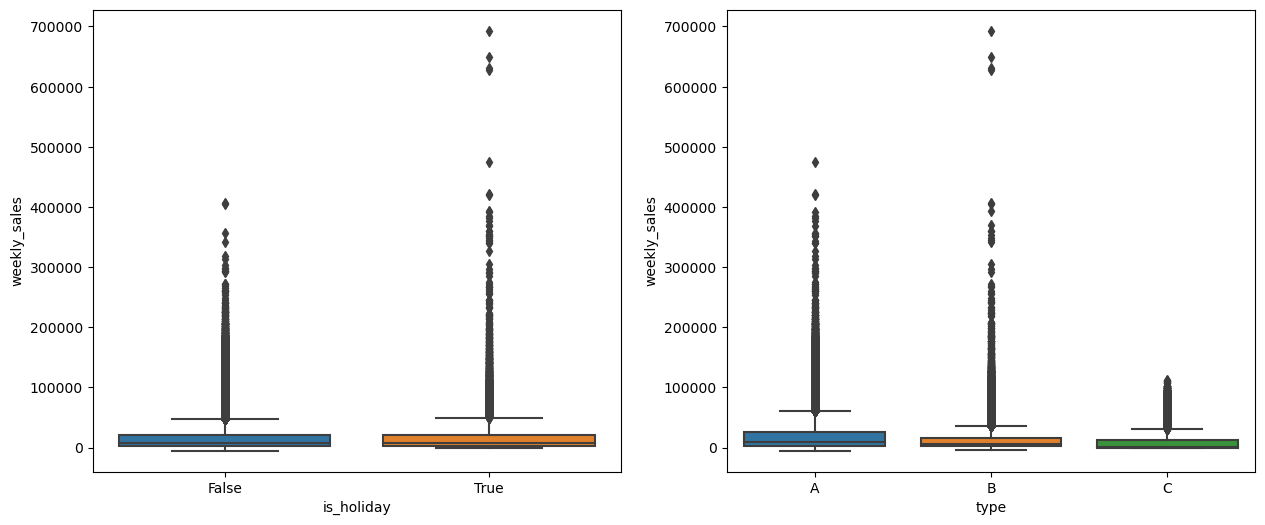

In [62]:
fig = plt.figure(figsize =(15, 6))

plt.subplot(1,2,1)
sns.boxplot(x='is_holiday',y='weekly_sales',data=df_full)

plt.subplot(1,2,2)
sns.boxplot(x='type',y='weekly_sales',data=df_full)

# Feature Engineering

In [64]:
df1 = df_full.copy()

### Mind Map 

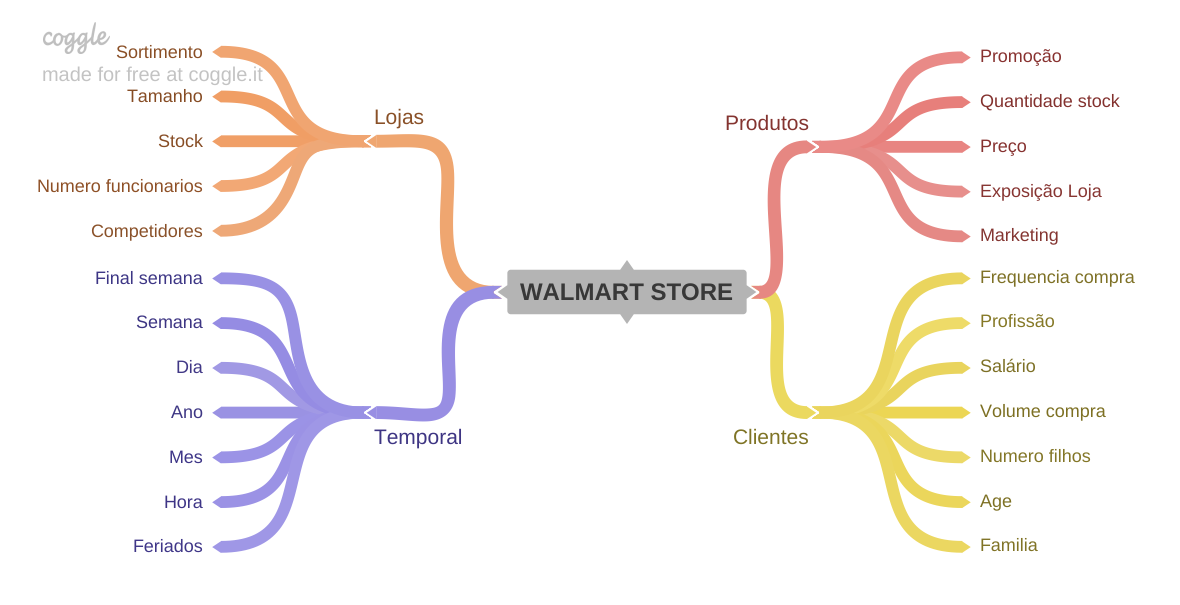

In [63]:
Image('img/WALMART_STORE.png')

#### Hypotheses List

1. As férias de natal são o periodo de maior faturamento?
2. O tipo de loja A é a que traz maior faturamento?
3. Quando o preço do cumbustivel é maior o faturamento diminui?
4. Enquanto maior a taxa de desmeprego o faturamento é menor?
5. A maior CPI menor é o faturamento?
6. O segundo semestre do ano temos um faturamento maior?

#### Feature Engineering

In [65]:
#Year
df1['year'] = df1['date'].dt.year
#Month
df1['month'] = df1['date'].dt.month
#Day
df1['day'] = df1['date'].dt.day
#week of year
df1['week_of_year'] = df1['date'].dt.weekofyear
#year week
df1['year_week'] = df1['date'].dt.strftime('%Y-%W')

In [67]:
df1['holiday'] = np.zeros(df1.shape[0])

df1.loc[(
    (df1.year==2010) & (df1.week_of_year==13))|
    ((df1.year==2011) & (df1.week_of_year==16))|
    ((df1.year==2012) & (df1.week_of_year==14)), 'holiday'] = 'Easter'

# Independece
df1.loc[(
    (df1.year==2010) & (df1.week_of_year==28))|
    ((df1.year==2011) & (df1.week_of_year==28))|
    ((df1.year==2012) & (df1.week_of_year==27)), 'holiday'] = 'Independence day'

# Christmas
df1.loc[(
    (df1.year==2010) & (df1.week_of_year==52))|
    ((df1.year==2011) & (df1.week_of_year==52))|
    ((df1.year==2012) & (df1.week_of_year==52)), 'holiday'] = 'Christmas'

# Thanksgiving
df1.loc[(
    (df1.year==2010) & (df1.week_of_year==47))|
    ((df1.year==2011) & (df1.week_of_year==47))|
    ((df1.year==2012) & (df1.week_of_year==47)), 'holiday'] = 'Thanksgiving'

# Labor day
df1.loc[(
    (df1.year==2010) & (df1.week_of_year==36))|
    ((df1.year==2011) & (df1.week_of_year==36))|
    ((df1.year==2012) & (df1.week_of_year==36)), 'holiday'] = 'Labor day'

# SuperBowl
df1.loc[(
    (df1.year==2010) & (df1.week_of_year==6))|
    ((df1.year==2011) & (df1.week_of_year==6))|
    ((df1.year==2012) & (df1.week_of_year==6)), 'holiday'] = 'SuperBowl'

df1['holiday'].value_counts()

0.0                 374236
SuperBowl             8895
Easter                8887
Labor day             8861
Independence day      8786
Thanksgiving          5959
Christmas             5946
Name: holiday, dtype: int64

In [70]:
df1.head()

,store,type,size,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,year,month,day,week_of_year,year_week,holiday
0,1,A,151315,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,5,2010-05,0.0
1,1,A,151315,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,12,6,2010-06,SuperBowl
2,1,A,151315,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,19,7,2010-07,0.0
3,1,A,151315,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,26,8,2010-08,0.0
4,1,A,151315,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,5,9,2010-09,0.0


### FILTRAGEM DE VARIAVEIS

In [71]:
df2 = df1.copy()

#### Filtragem de Linhas

In [73]:
df2 = df2[df2['weekly_sales']>0]

# Exploratory Data Analysis

In [108]:
df4 = df2.copy()

## Univariate Analysis 

<AxesSubplot:xlabel='weekly_sales', ylabel='Density'>

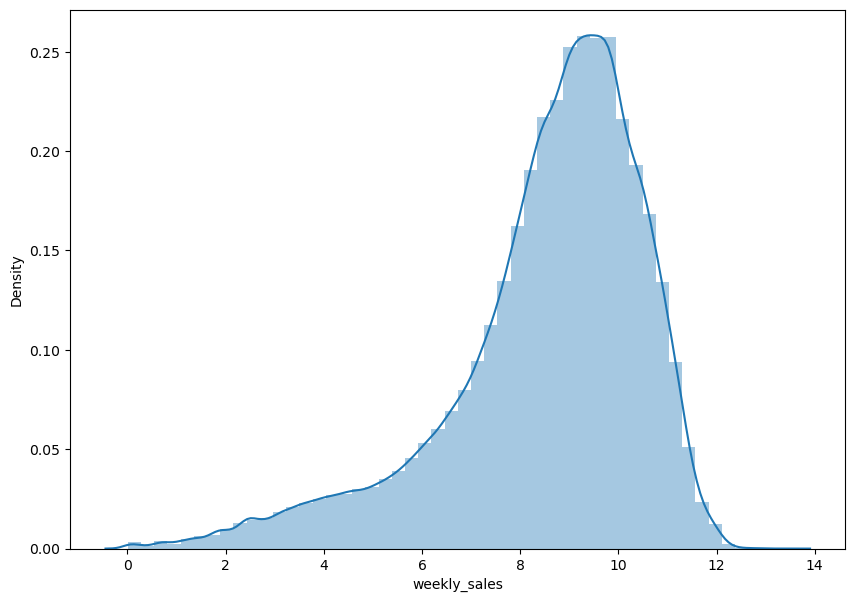

In [150]:
fig = plt.figure(figsize =(10, 7))
sns.distplot(np.log1p(df4['weekly_sales']))
# Aplicando transformação logaritmica
#Descobrir a distribuição dos dados, kurtosis. 

#### Numerical Attributes 

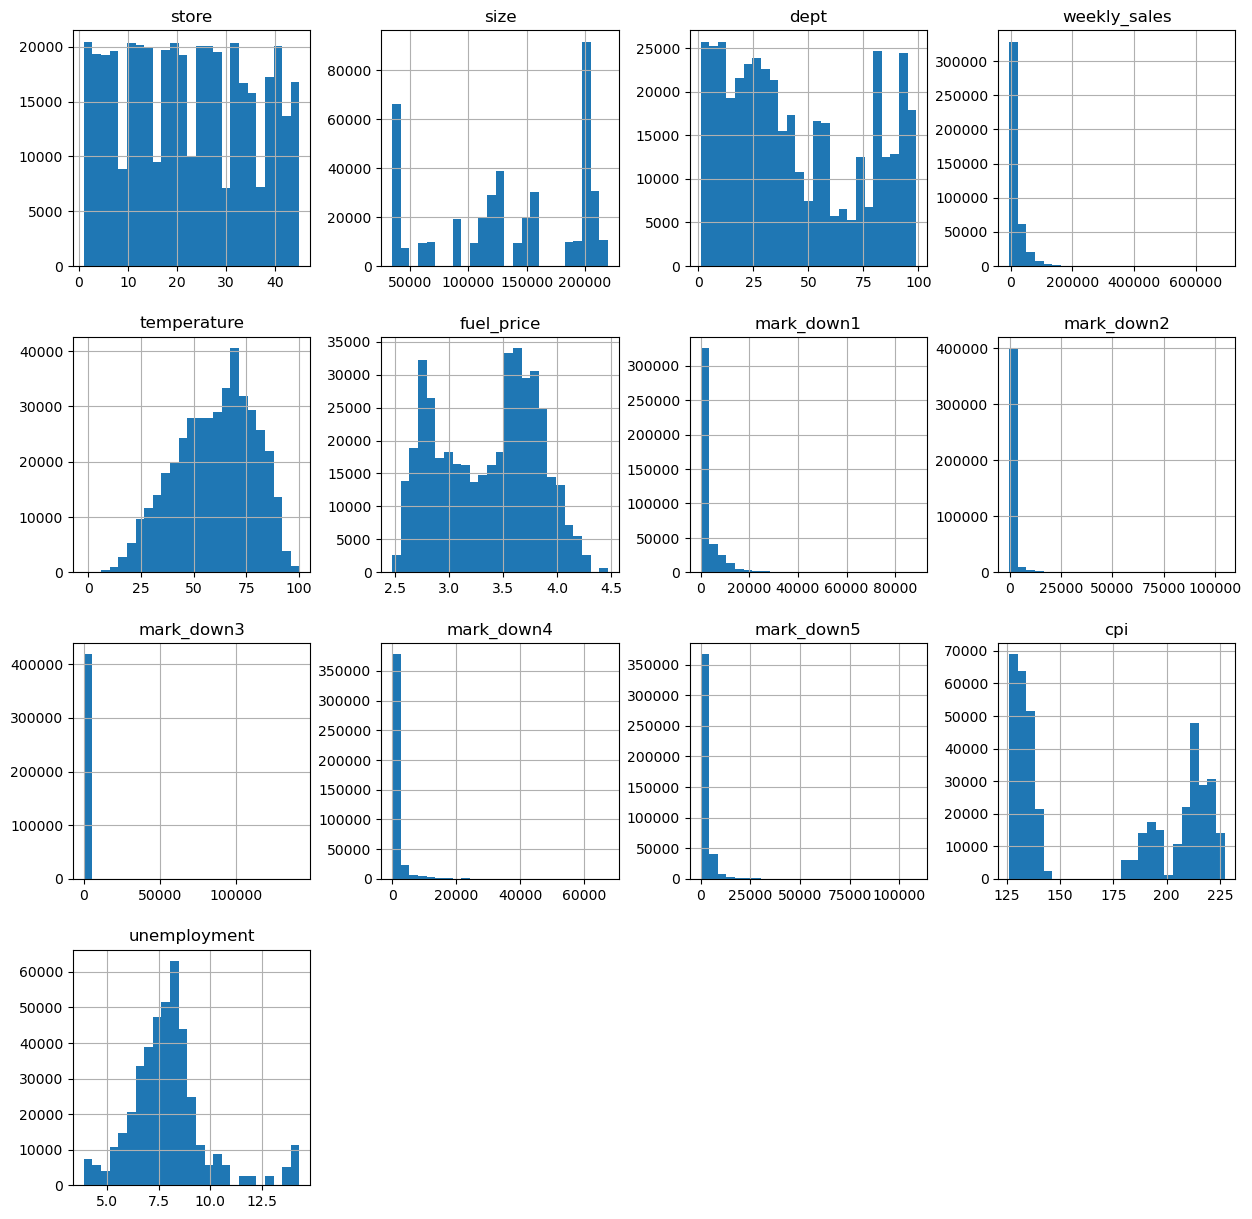

In [110]:
num_attributes.hist(figsize=(15, 15),bins = 25);

#### Categorical Attributes

<AxesSubplot:xlabel='weekly_sales', ylabel='Density'>

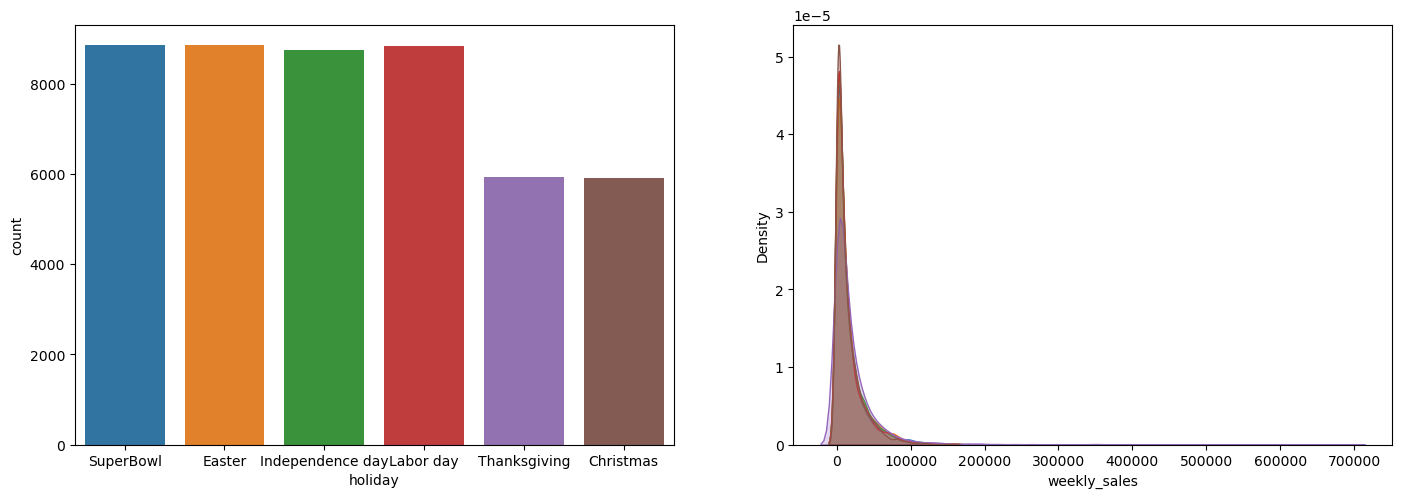

In [111]:
#State holiday
fig = plt.figure(figsize =(17, 12))

plt.subplot(2,2,1)
a = df4[df4['holiday']!= 0.0]

sns.countplot(a['holiday'])

plt.subplot(2,2,2)
sns.kdeplot(df4[df4['holiday'] =='SuperBowl']['weekly_sales'],label='SuperBowl',shade=True)
sns.kdeplot(df4[df4['holiday'] =='Easter']['weekly_sales'],label='Easter',shade=True)
sns.kdeplot(df4[df4['holiday'] =='Independence day']['weekly_sales'],label='Independence day',shade=True)
sns.kdeplot(df4[df4['holiday'] =='Labor day']['weekly_sales'],label='Labor day',shade=True)
sns.kdeplot(df4[df4['holiday'] =='Thanksgiving']['weekly_sales'],label='Thanksgiving',shade=True)
sns.kdeplot(df4[df4['holiday'] =='Christmas']['weekly_sales'],label='Christmas',shade=True)


<AxesSubplot:xlabel='weekly_sales', ylabel='Density'>

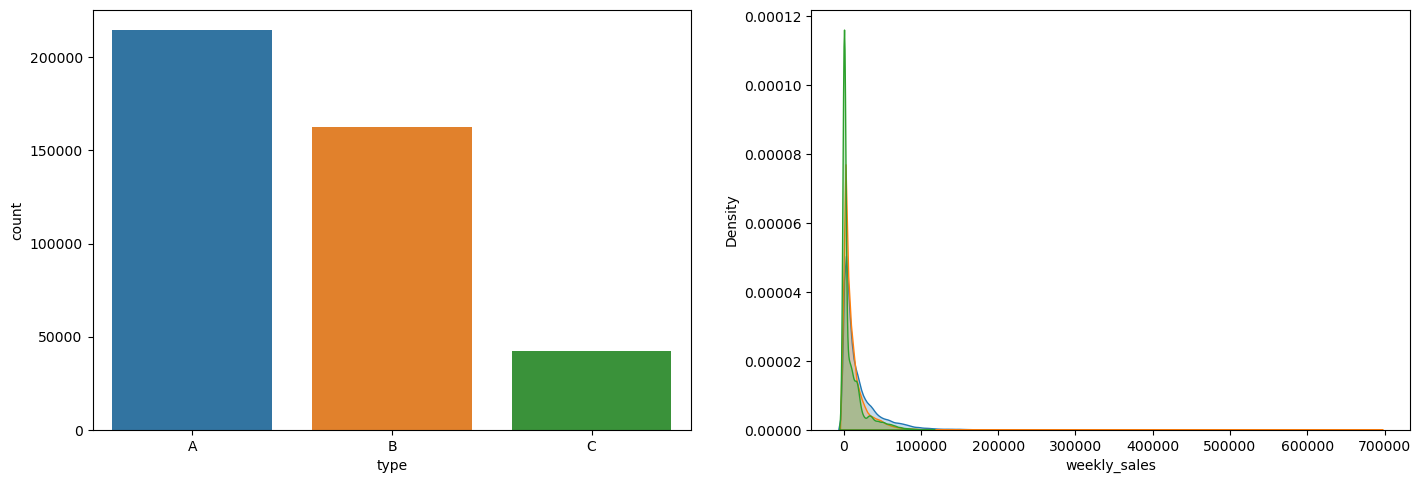

In [112]:
#Store_type
fig = plt.figure(figsize =(17, 12))

plt.subplot(2,2,1)
sns.countplot(df4['type'])

plt.subplot(2,2,2)
sns.kdeplot(df4[df4['type'] =='A']['weekly_sales'],label='A',shade=True)
sns.kdeplot(df4[df4['type'] =='B']['weekly_sales'],label='B',shade=True)
sns.kdeplot(df4[df4['type'] =='C']['weekly_sales'],label='C',shade=True)


## Bivariate Analysis

#### H1. O periodo do natal é o feriado de maior faturamento?

FALSO Natal é o periodo de férias onde se vende menos!

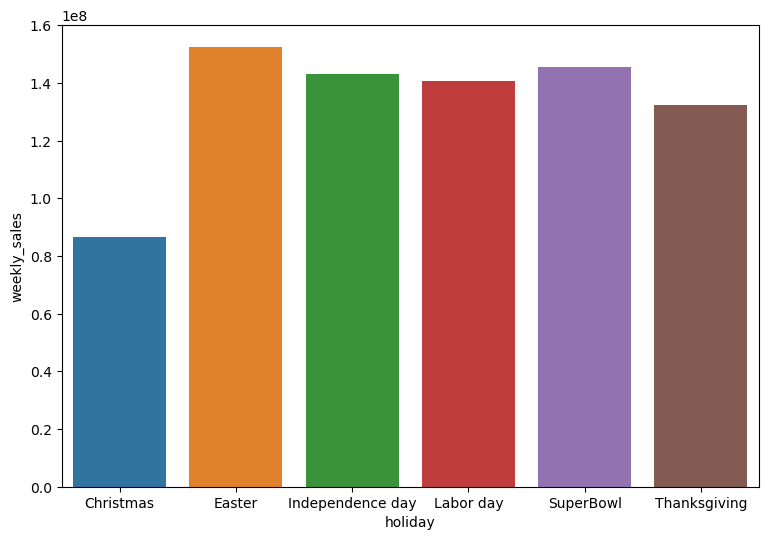

In [113]:
dfx = df4[df4['holiday']!= 0.0]

fig = plt.figure(figsize =(9, 6))
aux1 = dfx[['holiday','weekly_sales']].groupby('holiday').sum().reset_index()
sns.barplot(x='holiday',y='weekly_sales',data=aux1);

#### H2. O tipo de loja A é a que traz maior faturamento?

VERDADEIRO Loja de tipo A é a de maior faturamento.

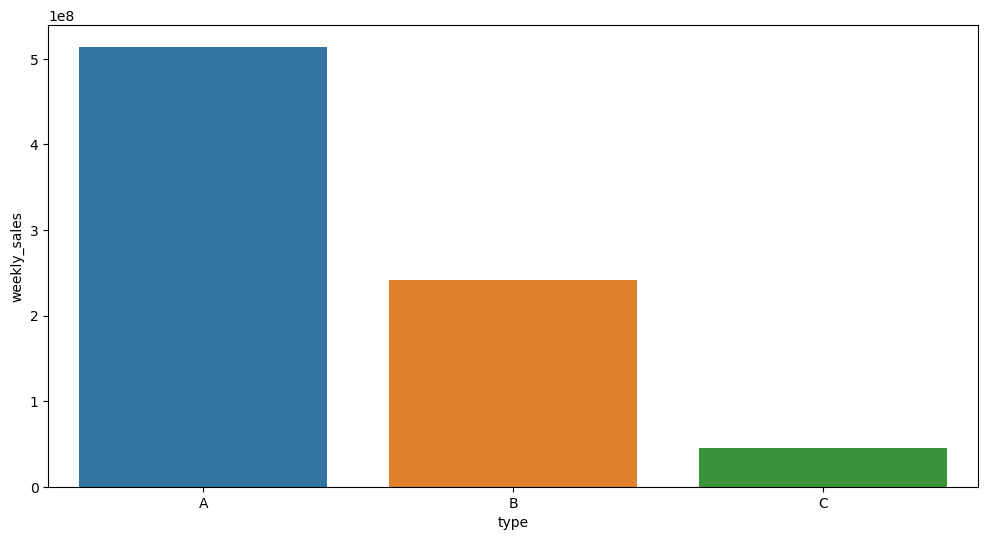

In [125]:
fig = plt.figure(figsize =(12, 6))

aux1 = dfx[['type','weekly_sales']].groupby('type').sum().reset_index()
sns.barplot(x='type',y='weekly_sales',data=aux1);


<AxesSubplot:xlabel='year_week'>

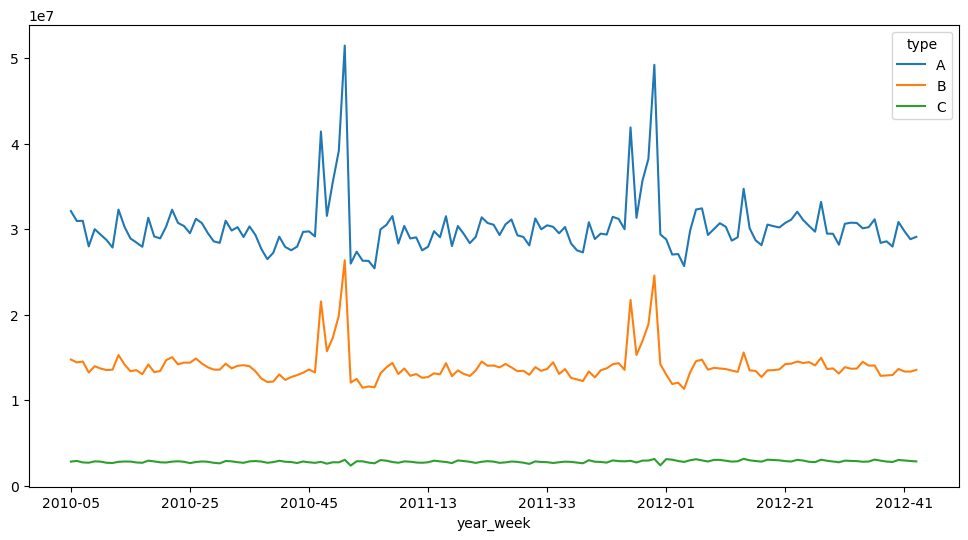

In [127]:
aux2 = df4[['year_week','type','weekly_sales']].groupby(['year_week','type']).sum().reset_index()
#fig = plt.figure(figsize =(10, 7))
aux2.pivot(index='year_week',columns='type',values='weekly_sales').plot(figsize =(12, 6))

#### H3. Lojas deveriam vender mais ao longo dos anos?

FALSO Lojas estão diminuindo o faturamento ao longo dos anos.

<br> Observação: Devemos considerar que nãoo conyamos com os dados de Novembro e Dezembro 2012.

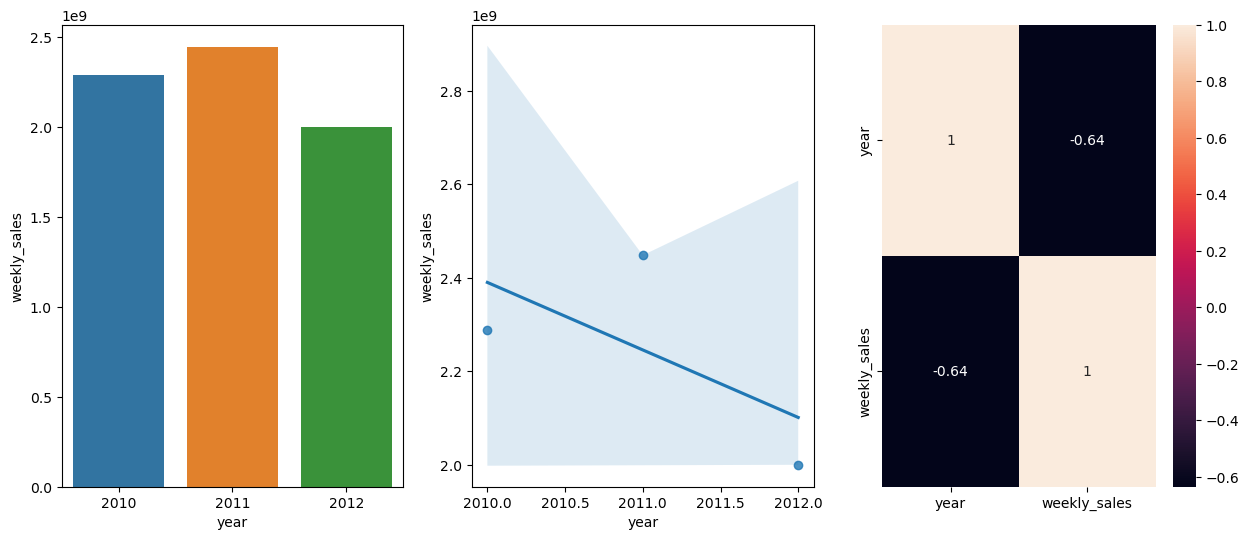

In [131]:
fig = plt.figure(figsize =(15, 6))
plt.subplot(1,3,1)
aux1=df4[['year','weekly_sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='weekly_sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='weekly_sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H4. Enquanto maior a taxa de desmeprego o faturamento é menor?

FALSO Enquanto a taxa de desemprego crece, o faturamento continua crescendo.

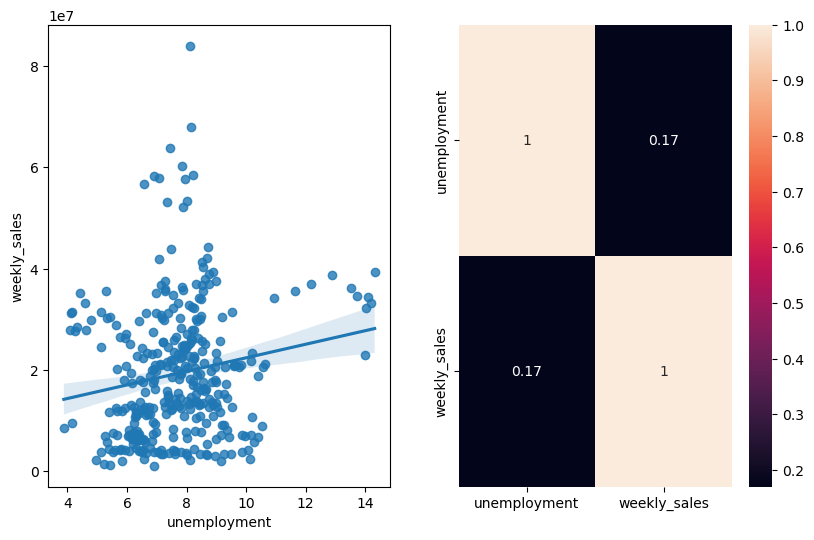

In [136]:
fig = plt.figure(figsize =(15, 6))
aux1=df4[['unemployment','weekly_sales']].groupby('unemployment').sum().reset_index()
plt.subplot(1,3,2)
sns.regplot(x='unemployment',y='weekly_sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H5. A maior CPI menor é o faturamento?

VERDADEIRO Enquanto maior o CPI menor é o faturamento

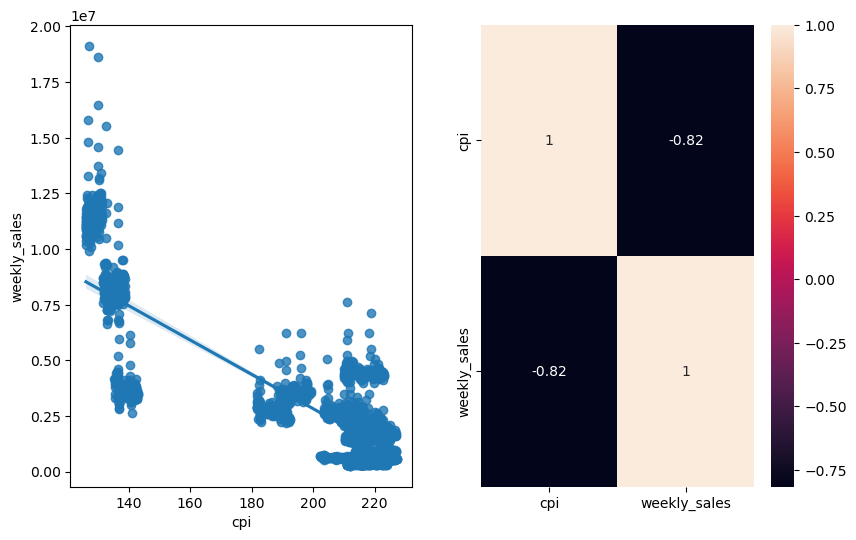

In [138]:
fig = plt.figure(figsize =(15, 6))
aux1=df4[['cpi','weekly_sales']].groupby('cpi').sum().reset_index()
plt.subplot(1,3,2)
sns.regplot(x='cpi',y='weekly_sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

#### H6. O segundo semestre do ano temos um faturamento maior?

VERDADEIRO O segundo semestre é o periodo de maior faturamento. 

<br>Observação: Devemos considerar que nãoo conyamos com os dados de Novembro e Dezembro 2012.

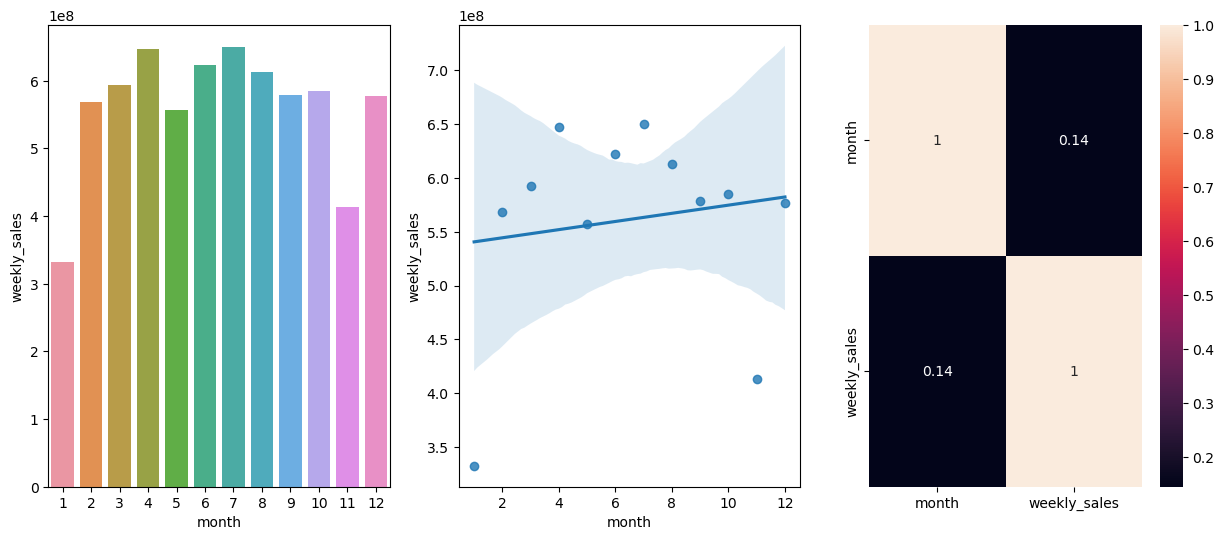

In [128]:
fig = plt.figure(figsize =(15, 6))
plt.subplot(1,3,1)
aux1=df4[['month','weekly_sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='weekly_sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='weekly_sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

## Multivariate Analysis

#### Numerical Attributes

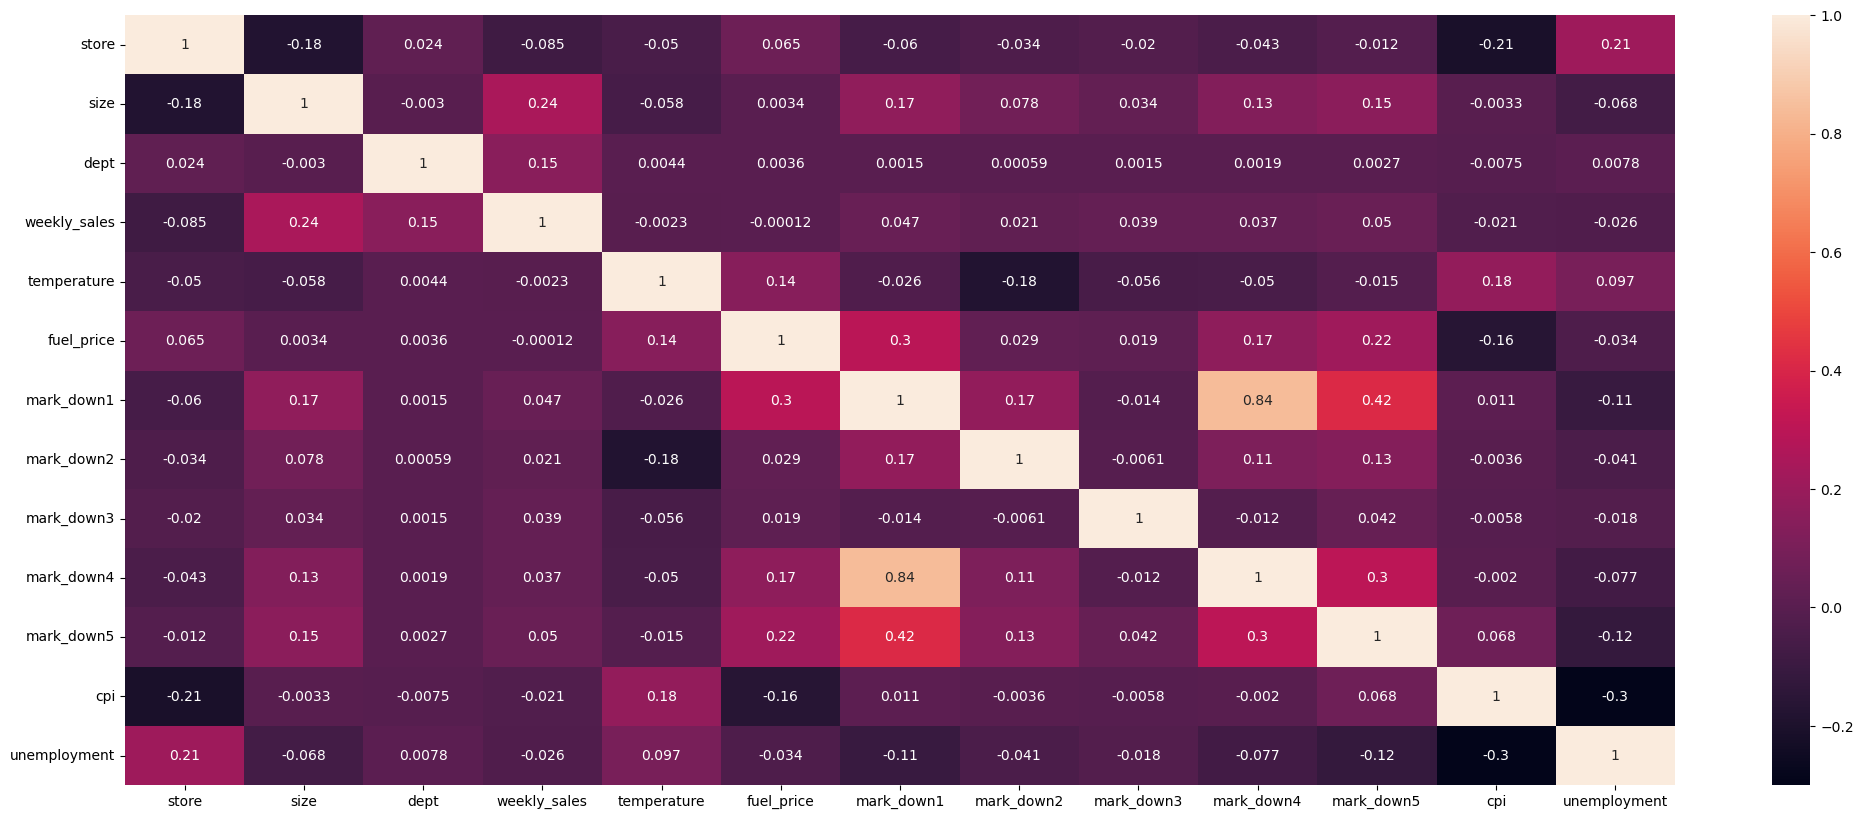

In [139]:
fig = plt.figure(figsize =(25, 10))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

#### Categorical Attributes

In [144]:
dfz = df4[df4['holiday']!= 0.0]

In [145]:
a =dfz.select_dtypes(include='object')
a.sample(10)

,type,year_week,holiday
380244,A,2010-28,Independence day
193141,A,2011-06,SuperBowl
360527,C,2010-28,Independence day
396543,C,2011-52,Christmas
8806,A,2010-13,Easter
400549,C,2011-28,Independence day
184869,A,2010-28,Independence day
349459,C,2012-36,Labor day
40404,B,2010-47,Thanksgiving
19869,A,2010-06,SuperBowl


In [143]:
#chi2
#Entrega 04 resultados. Teste baseado em Pearson, P-Valor, Grau de Liberdade, tabela de frequencia.
# No caso só vou me interessar pelo Teste, por isso [0]

In [151]:
#Chamando a função
a1 = cramer_v(a['holiday'],a['holiday'])
a2 = cramer_v(a['holiday'],a['type'])

a3 = cramer_v(a['type'],a['holiday'])
a4 = cramer_v(a['type'],a['type'])

d = pd.DataFrame({'state_holiday':[a1,a2],
              'store_type':[a3,a4],
             })

d = d.set_index(d.columns)

<AxesSubplot:>

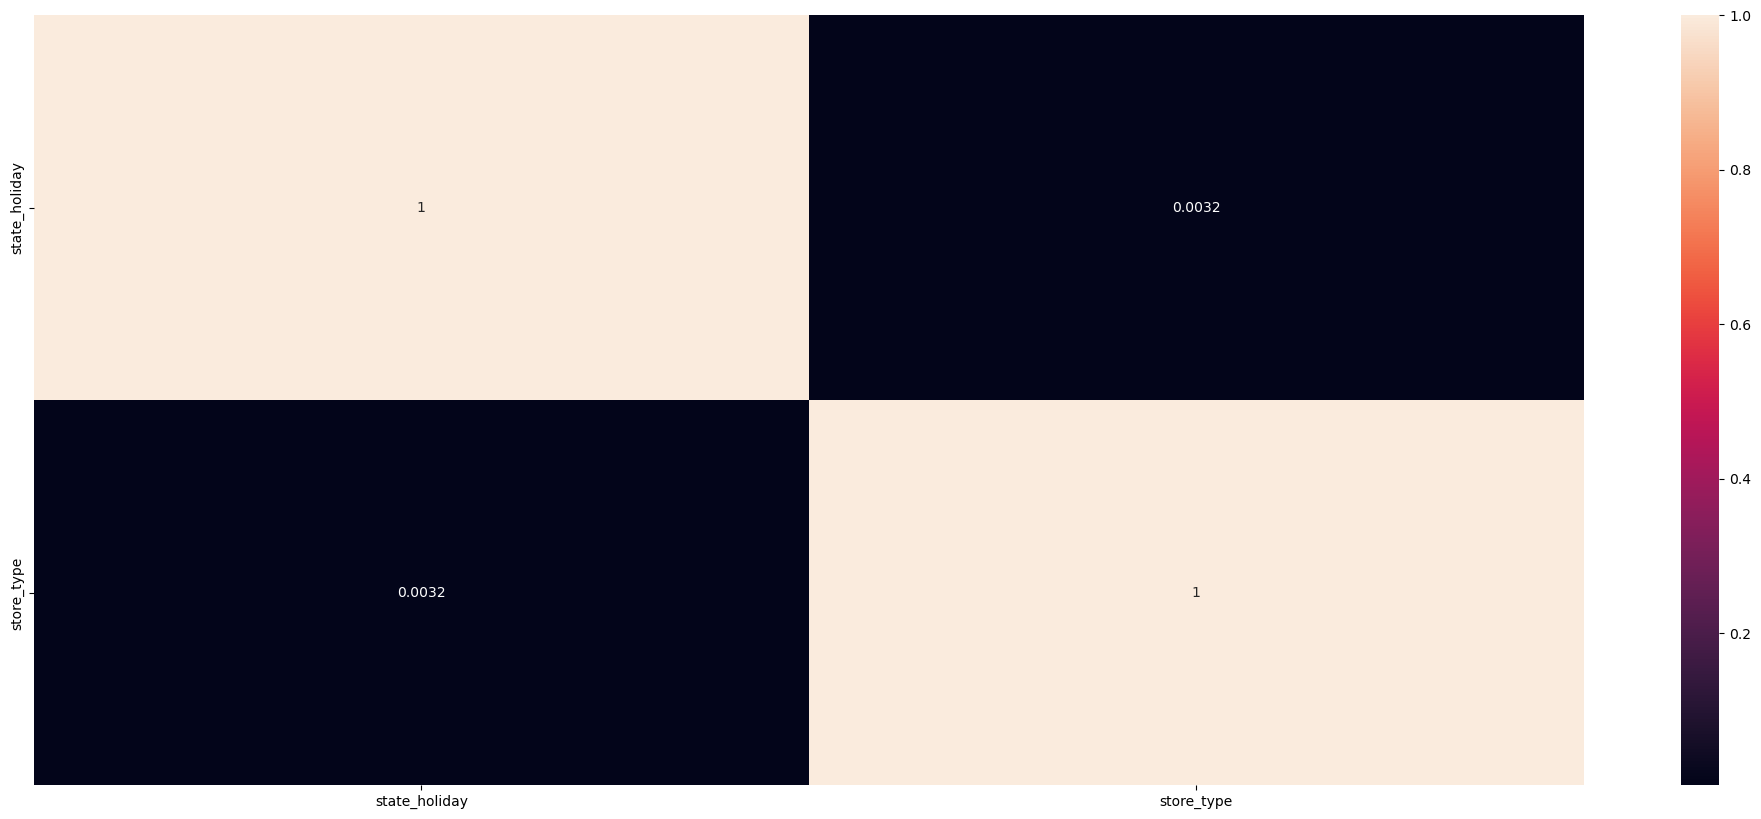

In [152]:
fig = plt.figure(figsize =(25, 10))
sns.heatmap(d,annot=True)

# Data Transformation

In [153]:
df5 = df4.copy()

In [158]:
df5.sample(5)

,store,type,size,dept,date,weekly_sales,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down5,cpi,unemployment,year,month,day,week_of_year,year_week,holiday
235572,24,A,203819,85,2011-09-30,1684.78,68.00,3.858,0.00,0.00,0.00,0.00,136.419500,8.358,2011,9,30,39,2011-39,0.0
245490,25,B,128107,83,2012-09-07,136.30,72.79,3.911,15308.07,0.00,22.06,1903.09,215.218957,7.280,2012,9,7,36,2012-36,Labor day
253445,26,A,152513,55,2012-03-23,6063.02,49.97,3.889,4336.70,150.86,4.59,2239.64,137.655290,7.467,2012,3,23,12,2012-12,0.0
269620,28,A,206302,20,2011-12-02,4399.67,52.50,3.701,10392.61,75.00,2241.11,19374.19,129.845967,12.890,2011,12,2,48,2011-48,0.0
8626,1,A,151315,83,2012-04-13,5938.04,69.07,3.891,6186.19,3288.69,17.07,1063.78,221.510210,7.143,2012,4,13,15,2012-15,0.0


In [156]:
cols_drop = ['is_holiday','mark_down4']
df5 = df5.drop(cols_drop, axis=1)

In [157]:
df5.shape 

(420212, 20)

### Rescaling

In [161]:
rs = RobustScaler()
mms = MinMaxScaler()

In [163]:
df5['size'] = rs.fit_transform(df5[['size']].values)
df5['dept'] = rs.fit_transform(df5[['dept']].values)
df5['temperature'] = rs.fit_transform(df5[['temperature']].values)
df5['fuel_price'] = rs.fit_transform(df5[['fuel_price']].values)
df5['mark_down1'] = rs.fit_transform(df5[['mark_down1']].values)
df5['mark_down2'] = rs.fit_transform(df5[['mark_down2']].values)
df5['mark_down3'] = rs.fit_transform(df5[['mark_down3']].values)
df5['mark_down5'] = rs.fit_transform(df5[['mark_down5']].values)
df5['cpi'] = rs.fit_transform(df5[['cpi']].values)
df5['unemployment'] = rs.fit_transform(df5[['unemployment']].values)

df5['year'] = mms.fit_transform(df5[['year']].values)

### Encoding

In [165]:
#label-encoder
le = LabelEncoder()
df5['type']= le.fit_transform(df5['type'])

# holidays - one hot enconding
df5 = pd.get_dummies(df5,prefix=['holiday'],columns=['holiday'])

In [166]:
df5['weekly_sales'] = np.log1p(df5['weekly_sales'])

### Transformação por Natureza

In [168]:
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi/30)))

#year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi/52)))

#day
#df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi/7)))
#df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi/7)))

# Feature Selection

In [169]:
df6 = df5.copy()

### Split Dataframe into training and test dataset

In [170]:
cols_drop=['week_of_year','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [171]:
df6.shape

(420212, 30)

In [173]:
# 06 semanas antes do último registro de venda - 
df6[['store','date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days=6*7)

Timestamp('2012-09-14 00:00:00')

In [174]:
# Training dataset
X_train = df6[df6['date']<'2012-09-14']
y_train = X_train['weekly_sales']

# Test dataset
X_test = df6[df6['date']>='2012-09-14']
y_test = X_test['weekly_sales']

print('Training Min Date:{}'.format(X_train['date'].min()))
print('Training Max Date:{}'.format(X_train['date'].max()))

print('\nTest Min Date:{}'.format(X_test['date'].min()))
print('Test Max Date:{}'.format(X_test['date'].max()))

Training Min Date:2010-02-05 00:00:00
Training Max Date:2012-09-07 00:00:00

Test Min Date:2012-09-14 00:00:00
Test Max Date:2012-10-26 00:00:00


### Boruta as feature Selector

In [175]:
# Define training and test for boruta
X_train_n = X_train.drop(['date','weekly_sales'], axis=1).values #values, não quero o dataframe completo
y_train_n = y_train.values.ravel()  #ravel pra colocar dentro de um vetor

# Define RFRegressor   (-1) para que use todos os cores da maquina criando as árvores em paralelo
rf = RandomForestRegressor(n_jobs = -1)

# Define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	16
Tentative: 	1
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	16
Tentative: 	1
Reject

### Best Features

In [176]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','weekly_sales'],axis = 1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [177]:
cols_selected_boruta

['store',
 'type',
 'size',
 'dept',
 'temperature',
 'fuel_price',
 'cpi',
 'unemployment',
 'year',
 'month',
 'day',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

### Manual Feature Selection

In [178]:
# Adicionando date e sales nas cols_seleccionadas para criar cols_selected_boruta_full

cols_selected_boruta = ['store',
                        'type',
                        'size',
                        'dept',
                        'temperature',
                        'fuel_price',
                        'cpi',
                        'unemployment',
                        'year',                        
                        'month_sin',
                        'month_cos',
                        'day_sin',
                        'day_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

#entram colunas date e sales 
feat_to_add =['date', 'weekly_sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)
#finally feat
x_training = X_train[cols_selected_boruta_full]

# Machine Learning Modeling

In [180]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

### Linear Regressor Model

In [183]:
# Model
lr = LinearRegression().fit(x_train, y_train)
# Prediction
yhat_lr = lr.predict(x_test)
# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Modelo Name,MAE,MAPE,RMSE
0,Linear Regression,12463.135687,324.981125,22788.217624


#### Linear Regression - Validation

In [186]:
lr_result_cv = cross_validation(x_training,5, 'Linear Regression', lr)    
lr_result_cv    


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,13221.93 +/- 157.73,350.14 +/- 274.79,23954.79 +/- 296.3


### Random Forest Model

In [187]:
from sklearn.ensemble import RandomForestRegressor
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=42).fit(x_train, y_train)
# Prediction
yhat_rf = rf.predict(x_test)
# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Modelo Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1425.663279,0.420884,3251.326342


#### Random Forest - Validation

In [188]:
rf_result_cv = cross_validation(x_training,5, 'Random Forest Regressor', rf)
rf_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1529.93 +/- 176.88,2.67 +/- 1.84,3283.88 +/- 419.37


### XGBoost Regressor

In [189]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators = 100,
                            eta = 0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9 ).fit(x_train, y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Modelo Name,MAE,MAPE,RMSE
0,XGBoost Regressor,14901.687039,1.275286,25985.981402


#### XGBoost Regressor - Validation

In [190]:
xgb_result_cv = cross_validation(x_training,5, 'XGBoost Regressor', model_xgb)    
xgb_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,15607.08 +/- 165.82,1.77 +/- 0.52,26910.7 +/- 261.52


### Compare Model performance

#### Real Performance - Cross Validation

In [191]:
modelling_result_cv = pd.concat( [lr_result_cv,rf_result_cv,xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,13221.93 +/- 157.73,350.14 +/- 274.79,23954.79 +/- 296.3
0,XGBoost Regressor,15607.08 +/- 165.82,1.77 +/- 0.52,26910.7 +/- 261.52
0,Random Forest Regressor,1529.93 +/- 176.88,2.67 +/- 1.84,3283.88 +/- 419.37


# Hyperparameter Fine Tuning 

In [192]:
import random

In [193]:
param ={
    'n_estimators':[1500,1700,2500,3000,3500],
    'eta':[0.01, 0.03],
    'max_depth':[3,5,9],
    'subsample':[0.1,0.5,0.7],
    'colsample_bytree':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15]
}

MAX_EVAL = 5

In [194]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #escolher valores para parametros randomicamente
    hp = { k: random.sample(v, 1 )[0] for k, v in param.items() }
    print(hp)
    # Model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators = hp['n_estimators'],
                             eta = hp['eta'],
                             max_depth=hp['max_depth'],
                             subsample=hp['subsample'],
                             colsample_bytree=hp['colsample_bytree'],
                             min_child_weight =hp['min_child_weight'])

    # Performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,4854.33 +/- 263.71,7.69 +/- 2.18,9294.89 +/- 581.98
0,XGBoost Regressor,3482.51 +/- 115.04,4.75 +/- 1.7,6779.11 +/- 285.28
0,XGBoost Regressor,2822.36 +/- 70.29,3.74 +/- 2.08,5640.81 +/- 153.36
0,XGBoost Regressor,4364.74 +/- 145.5,7.81 +/- 3.33,8471.87 +/- 387.15
0,XGBoost Regressor,4523.39 +/- 192.61,7.11 +/- 2.93,8792.09 +/- 410.13


# Final Model

In [195]:
param_tuned ={
    'n_estimators': 3500, 
    'eta': 0.03, 
    'max_depth': 5, 
    'subsample': 0.7, 
    'colsample_bytree': 0.9, 
    'min_child_weight': 15
    }

In [196]:
# Modelo
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight =param_tuned['min_child_weight']).fit(x_train, y_train)
# prediction 
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Modelo Name,MAE,MAPE,RMSE
0,XGBoost Regressor,2532.567219,2.383446,5088.834888


# Error Interpretation

### Business Performance

In [197]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['weekly_sales'] = np.expm1(df9['weekly_sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

In [199]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store','weekly_sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['weekly_sales'],x['predictions'] )).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','weekly_sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['weekly_sales'],x['predictions'] )).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1 ,df9_aux2, how='inner', on='store')
df92 = pd.merge(df91,df9_aux3,how='inner', on='store')

#Merge
df9_aux3 = pd.merge(df9_aux1 ,df9_aux2, how='inner', on='store')
df92 = pd.merge(df91,df9_aux3,how='inner', on='store')

# Cenários
df92['pior_cenario'] = df92['predictions'] - df92['MAE']
df92['melhor_cenario'] = df92['predictions'] + df92['MAE']

#Ordem Colunas
df92 = df92[['store','predictions','pior_cenario','melhor_cenario','MAE','MAPE']]

In [223]:
df92['predictions'] = round(df92['predictions'],2)
df92['pior_cenario'] = round(df92['pior_cenario'],2)
df92['melhor_cenario'] = round(df92['melhor_cenario'],2)
df92['MAE'] = round(df92['MAE'],2)
df92['MAPE'] = round(df92['MAPE'],2)

In [224]:
df92.head(10)

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
0,1,10139293.00,10136568.64,10142017.36,2724.36,0.31
1,2,12634685.00,12630778.40,12638591.60,3906.60,0.34
2,3,2890627.75,2888986.20,2892269.80,1641.80,0.44
3,4,14484596.00,14480507.84,14488686.16,4089.16,0.47
4,5,2303352.50,2302487.06,2304217.94,865.44,0.34
5,6,10521671.00,10518303.59,10525038.41,3367.41,0.58
6,7,3884294.75,3882323.52,3886265.98,1971.23,0.99
7,8,6735709.00,6733776.72,6737641.28,1932.28,2.53
8,9,3781310.50,3779780.07,3782840.93,1530.43,0.60
9,10,12104433.00,12100288.33,12108575.67,4143.67,0.30


In [225]:
# Existem lojas mais desafiadoras que outras

df92.sort_values('MAPE', ascending=False).head(45)

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
18,19,1.021011e+07,10206714.20,10213497.80,3391.80,51.01
19,20,1.223664e+07,12230551.89,12242722.11,6085.11,17.15
10,11,9.713862e+06,9710628.89,9717095.11,3233.11,2.62
11,12,6.348766e+06,6346017.15,6351516.85,2749.85,2.55
7,8,6.735709e+06,6733776.72,6737641.28,1932.28,2.53
38,39,1.052941e+07,10526487.50,10532336.50,2924.50,2.32
34,35,5.006182e+06,5002560.56,5009802.44,3620.94,1.53
21,22,6.557688e+06,6555320.22,6560054.78,2367.28,1.50
42,43,4.341240e+06,4339439.14,4343041.86,1801.36,1.50
13,14,1.151770e+07,11514308.47,11521097.53,3394.53,1.35


<AxesSubplot:xlabel='store', ylabel='MAPE'>

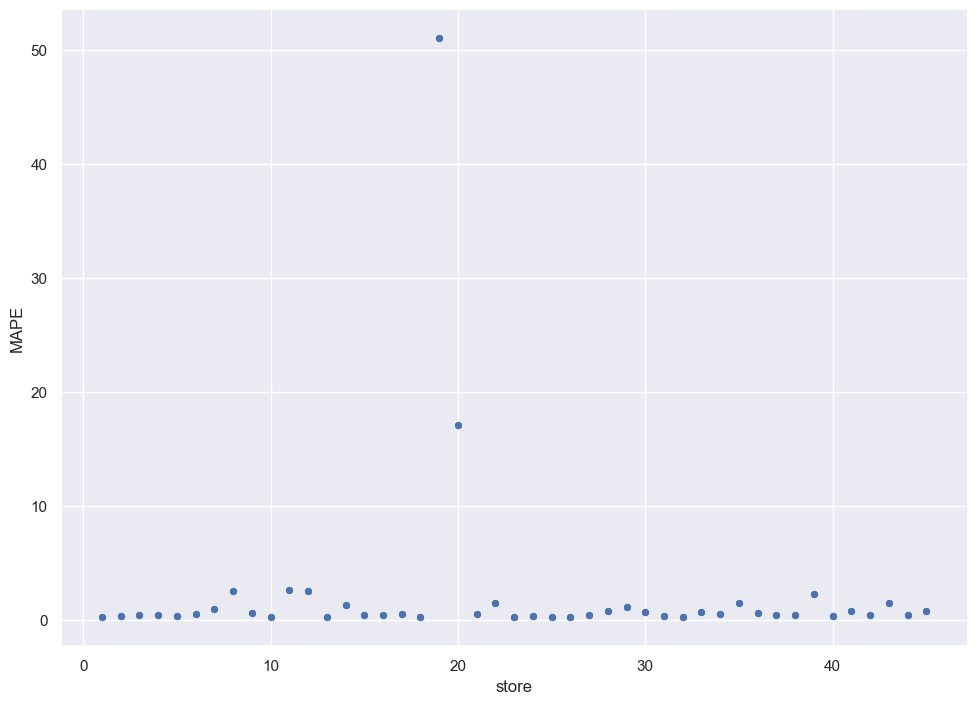

In [226]:
#MOstrando gráficamente
sns.scatterplot(x='store',y='MAPE', data=df92)

### Total Performance

In [227]:
df93 = df92[['predictions','pior_cenario','melhor_cenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Cenarios', 0:'Valores'})

df93['Valores'] = df93['Valores'].map('R${:,.2f}'.format)  
df93

,Cenarios,Valores
0,predictions,"R$310,393,952.00"
1,pior_cenario,"R$310,283,560.91"
2,melhor_cenario,"R$310,504,391.84"


### Machine Learning Performance

In [228]:
df9['error'] = df9['weekly_sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['weekly_sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

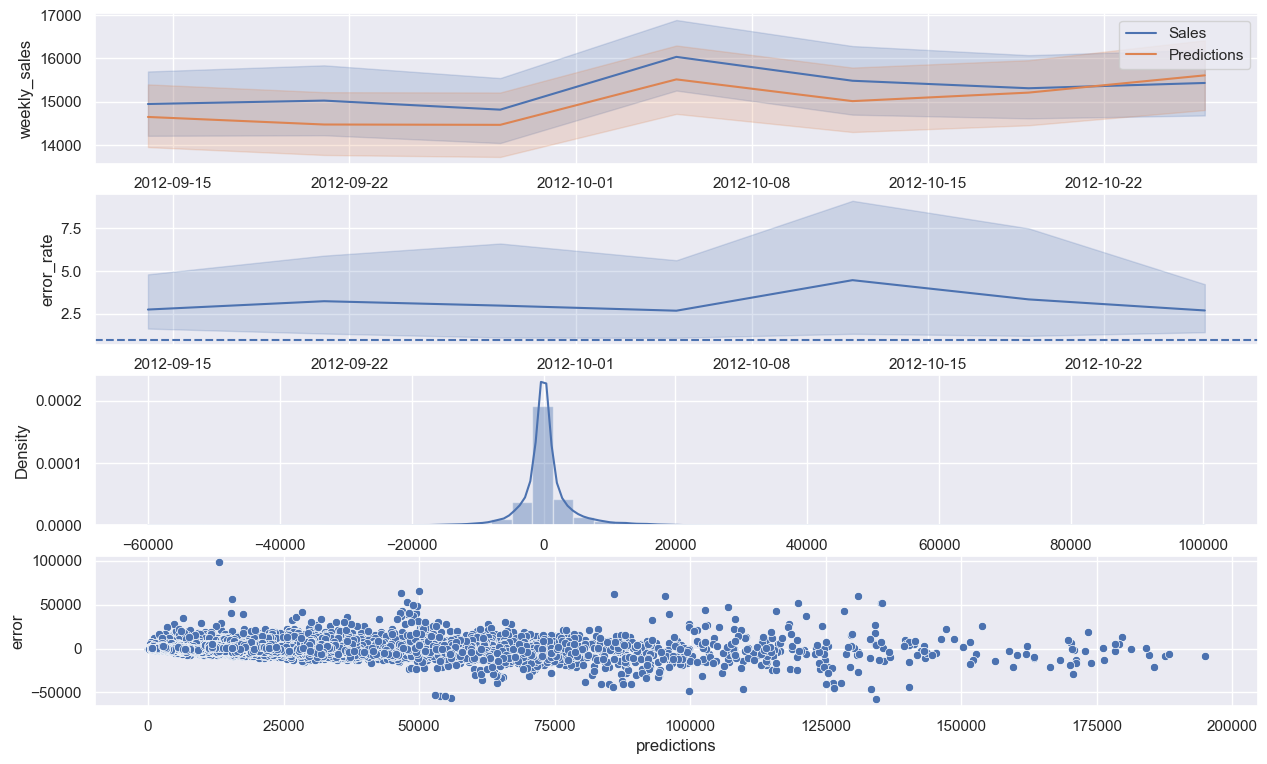

In [229]:
fig = plt.figure(figsize =(15, 9))

plt.subplot(4,1,1)
sns.lineplot(x='date', y='weekly_sales',data=df9,label='Sales')
sns.lineplot(x='date', y='predictions',data=df9,label='Predictions')

#Acima da linha 1 é pq meu modelo fez uma superstimação
#Debaixo da linha 1 é pq meu modelo fez uma subestimação
plt.subplot(4,1,2)
sns.lineplot(x='date', y='error_rate',data=df9)
plt.axhline(1, linestyle='--')

#Gráfico de Análise de Resíduo
plt.subplot(4,1,3)
sns.distplot(df9['error'])

#O modelo deve ficar dentro de um tubo imaginário
plt.subplot(4,1,4)
sns.scatterplot(df9['predictions'],df9['error'])

## Next Steps

 Analisar lojas Outliers. 